# **In-Class Assignment: Topic Modeling**

## *IS 5150*
## Name: Cailean

Key-phrase extraction relatively simple and easy to implement, but doesn't always yield the most useful information in regards to determining a document's overall theme/topic. Topic modeling is a more sophisticated approach to extracting topics/themes from a corpus, and there are several unsupervised approaches that can accomplish this text mining task:

*   Latent Semantic Indexing
*   Latent Dirichlet Allocation


In this notebook, I implement the above methods on a corpus of research papers from the NeurIPS conference to try and extract meaningful topic labels for these papers.

In [ ]:
# load all dependencies

import nltk
nltk.download(['stopwords', 'wordnet', 'omw-1.4'])  #stopwords, wordnet, omw-1.4
import gensim

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## **1) Data Retrieval**

Download the dataset directly using the following commands:

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2022-11-03 01:05:56--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  9.11MB/s    in 1.3s    

2022-11-03 01:05:57 (9.11 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



#### **A) Data Extraction**

Uncompress this tgz file and extract the different text files within each of the subfolders, like so:

In [ ]:
!tar -xzf nips12raw_str602.tgz

In [ ]:
DATA_PATH = '/content/nipstxt'
print(os.listdir(DATA_PATH))

In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
                                                                                                                              # Read all texts into a list
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + '/' + folder )
    for file_name in file_names:
        with open(DATA_PATH + '/' + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

**If using Jupyter notebooks/labs using this instead**

In [ ]:
# """
# folders = ["nips{0:02}".format(i) for i in range(0,13)]
# # Read all texts into a list.
# papers = []
# for folder in folders:
#     file_names = os.listdir(DATA_PATH + folder)
#     for file_name in file_names:
#         with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
#             data = f.read()
#         papers.append(data)
# len(papers)
# """

In [ ]:
print(papers[0][:1000])

201 
NEW HARDWARE FOR MASSIVE NEURAL NETWORKS 
D. D. Coon and A. G. U. Perera 
Applied Technology Laboratory 
University of Pittsburgh 
Pittsburgh, PA 15260. 
ABSTRACT 
Transient phenomena associated with forward biased silicon p+ - n - n + struc- 
tures at 4.2K show remarkable similarities with biological neurons. The devices play 
a role similar to the two-terminal switching elements in Hodgkin-Huxley equivalent 
circuit diagrams. The devices provide simpler and more realistic neuron emulation 
than transistors or op-amps. They have such low power and current requirements 
that they could be used in massive neural networks. Some observed properties of 
simple circuits containing the devices include action potentials, refractory periods, 
threshold behavior, excitation, inhibition, summation over synaptic inputs, synaptic 
weights, temporal integration, memory, network connectivity modification based on 
experience, pacemaker activity, firing thresholds, coupling to sensors with grade

## **2) Basic Text Preprocessing**

I create a separate normalize_corpus function here, because I don't need to do all the steps we normally would. This is going to save us some time in its execution.

In [ ]:
%%time

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower() # set paper to lowercase
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)] # tokenize paper and strip extra whitespaces
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]  # lemmatize tokens
        paper_tokens = [token for token in paper_tokens if len(token) > 1] # remove tokens shorter than 1 character or shorter
        paper_tokens = [token for token in paper_tokens if token not in stop_words] # remove stopwords
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)

    return norm_papers

norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 27.5 s, sys: 180 ms, total: 27.7 s
Wall time: 28.1 s


In [ ]:
print(norm_papers[0][:100])

['new', 'hardware', 'massive', 'neural', 'network', 'coon', 'perera', 'applied', 'technology', 'laboratory', 'university', 'pittsburgh', 'pittsburgh', 'pa', 'abstract', 'transient', 'phenomenon', 'associated', 'forward', 'biased', 'silicon', 'struc', 'tures', '2k', 'show', 'remarkable', 'similarity', 'biological', 'neuron', 'device', 'play', 'role', 'similar', 'two', 'terminal', 'switching', 'element', 'hodgkin', 'huxley', 'equivalent', 'circuit', 'diagram', 'device', 'provide', 'simpler', 'realistic', 'neuron', 'emulation', 'transistor', 'op', 'amp', 'low', 'power', 'current', 'requirement', 'could', 'used', 'massive', 'neural', 'network', 'observed', 'property', 'simple', 'circuit', 'containing', 'device', 'include', 'action', 'potential', 'refractory', 'period', 'threshold', 'behavior', 'excitation', 'inhibition', 'summation', 'synaptic', 'input', 'synaptic', 'weight', 'temporal', 'integration', 'memory', 'network', 'connectivity', 'modification', 'based', 'experience', 'pacemaker',

## 3) **Feature Engineering**

Before performing any sort of vectorization, I narrow down the pool of words to more common n-grams; specifically bigrams that have occurred in the text at least 20 times. This is going to cut down on the number of words to vectorize.

In [ ]:
# ~ number of words in corpus
len(set(norm_papers[2]))*1740

In [ ]:
bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_')                     # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['new', 'hardware', 'massive', 'neural_network', 'coon', 'perera', 'applied', 'technology', 'laboratory', 'university_pittsburgh', 'pittsburgh_pa', 'abstract', 'transient', 'phenomenon', 'associated', 'forward', 'biased', 'silicon', 'struc', 'tures', '2k', 'show', 'remarkable', 'similarity', 'biological', 'neuron', 'device', 'play_role', 'similar', 'two', 'terminal', 'switching', 'element', 'hodgkin_huxley', 'equivalent', 'circuit_diagram', 'device', 'provide', 'simpler', 'realistic', 'neuron', 'emulation', 'transistor', 'op', 'amp', 'low_power', 'current', 'requirement', 'could', 'used']


> #### **A) Extract bigrams from full corpus to create a condensed vocab set of high frequency phrases**

In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)                                                   # Create a dictionary representation of the documents
print('Sample word to number mappings:', list(dictionary.items())[:15])                                       # print out sample of dictionary
print('Total Vocabulary Size:', len(dictionary))                                                              # print total vocab size

Sample word to number mappings: [(0, '100fa'), (1, '10ma'), (2, '2k'), (3, '2o3'), (4, '2o6'), (5, '80er10667'), (6, 'ability'), (7, 'abruptly'), (8, 'abstract'), (9, 'ac'), (10, 'acad_sci'), (11, 'accomplished'), (12, 'accomplishes'), (13, 'accumulation'), (14, 'acheivable')]
Total Vocabulary Size: 78892


> #### **B) Prune the vocab set by removing words that occur in fewer than 20 documents or more than 60% of documents**

**What is the logic behind this step?**

We don't need to include very frequent or very infrequent words/bigrams; those typically don't add much value to the meaning of the text.

In [ ]:
dictionary.filter_extremes(no_below=20, no_above=0.60)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


> #### **C) Bag of Words Vectorization**

Great! Now with a much more reasonable vocab size, I won't have so many dimensions. Let's create the BOW corpus from the dictionary of bigrams.

In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(1, 3), (4, 1), (9, 1), (14, 11), (15, 1), (17, 1), (18, 2), (21, 1), (26, 1), (27, 1), (28, 3), (30, 4), (31, 1), (35, 1), (41, 10), (42, 7), (45, 1), (46, 2), (50, 1), (52, 1), (54, 2), (55, 2), (60, 4), (64, 1), (73, 1), (82, 6), (84, 1), (86, 1), (93, 1), (94, 3), (95, 5), (96, 3), (98, 5), (100, 1), (102, 3), (107, 4), (109, 1), (110, 3), (113, 1), (121, 7), (122, 2), (126, 1), (131, 1), (134, 2), (136, 3), (146, 1), (150, 1), (153, 1), (154, 1), (155, 1)]


**What does each tuple represent here?**

A word index and its frequency in document 01.

In [ ]:
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('acad_sci', 1), ('according', 1), ('addition', 1), ('american_institute', 1), ('application', 2), ('approximation', 2), ('assume', 2), ('assumption', 5), ('available', 1), ('average', 4), ('averaged', 1), ('best', 3), ('binocular', 1), ('cannot', 1), ('center', 2), ('change', 6), ('class', 1), ('compared', 1), ('complex', 1), ('component', 3), ('computation', 5), ('computed', 4), ('computing', 3), ('consider', 1), ('consistent', 1), ('constant', 5), ('constraint', 8), ('contain', 1), ('corresponding', 4), ('could', 1), ('critical', 1), ('dark', 2), ('define', 1), ('density', 1), ('difference', 1), ('discussed', 1), ('due', 2), ('ed', 3), ('effect', 3), ('effective', 1), ('either', 1), ('equation', 2), ('et_al', 1), ('evolution', 1), ('experiment', 1), ('explicit', 1), ('eye', 1), ('fact', 1), ('fairly', 1), ('find', 3)]


## **4) Topic Modeling with Latent Semantic Indexing (LSI)**

I use latent semantic indexing first to generate a topic model. I set the total number of topics to 10 and then examine which words are most influential for each topic.

In [ ]:
%%time
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 4min 55s, sys: 1min 50s, total: 6min 46s
Wall time: 3min 53s


> #### **A) Print topics (top 20 words per 10 topics)**

In [ ]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
0.487*"neuron" + 0.396*"cell" + -0.257*"state" + 0.191*"response" + -0.187*"training" + 0.170*"stimulus" + 0.117*"activity" + -0.109*"class" + 0.099*"spike" + 0.097*"pattern" + 0.096*"circuit" + 0.096*"synaptic" + -0.095*"vector" + 0.090*"signal" + 0.090*"firing" + 0.088*"visual" + -0.084*"classifier" + -0.083*"action" + -0.078*"word" + 0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"classifica

**Like a correlation coefficient, the larger the associated weight, the stronger the influence of a word within a topic. But what does it mean for a topic to have words with positive and negative weights?**

Two main ideas being captured within one topic, when we have both positive and negative values.

In [ ]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.487), ('cell', 0.396), ('response', 0.191), ('stimulus', 0.17), ('activity', 0.117), ('spike', 0.099), ('pattern', 0.097), ('circuit', 0.096), ('synaptic', 0.096), ('signal', 0.09), ('firing', 0.09), ('visual', 0.088), ('cortical', 0.078)]
--------------------------------------------------
Direction 2: [('state', -0.257), ('training', -0.187), ('class', -0.109), ('vector', -0.095), ('classifier', -0.084), ('action', -0.083), ('w

**Spend some time examining the different words amongst topics 1-10 and their 2 subtopics; what are some themes/possible topics that emerge?**

Can indicate two distrinct sub-topics (two directions) within one topic.

> #### **B) Apply SVD to decompose our term-document matrix into term-topic, topic-topic, and topic-document matrices**

In [ ]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((7756, 10), (10,), (10, 1740))

> #### **C) Transpose to Document Topic Matrix**

In [ ]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3),
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.023,0.028,-0.018,-0.015,0.006,-0.032,-0.009,-0.011,0.049,0.021
1,0.041,-0.014,-0.017,0.032,-0.018,-0.003,0.062,-0.005,-0.001,0.021
2,0.016,0.017,-0.013,-0.008,0.024,-0.028,0.000,0.019,-0.008,-0.006
3,0.035,-0.002,-0.017,0.008,0.016,-0.017,0.032,0.022,0.050,0.029
4,0.022,-0.004,-0.033,-0.008,-0.029,0.008,-0.009,0.007,-0.016,0.003
5,0.017,0.020,-0.007,-0.013,0.003,0.030,0.009,-0.009,0.035,0.017
6,0.020,0.034,-0.019,-0.003,0.017,-0.042,-0.012,0.014,0.002,-0.012
7,0.045,-0.007,-0.002,0.030,0.024,0.007,-0.027,0.009,0.019,-0.049
8,0.029,0.052,0.001,0.021,0.003,0.055,-0.041,0.052,0.019,-0.013
9,0.017,-0.002,-0.009,-0.011,0.017,-0.002,0.027,0.009,-0.002,0.005


In [ ]:
document_numbers = [8, 150, 200]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #8:
Dominant Topics (top 3): ['T6', 'T2', 'T8']
Paper Summary:
709 
TIME-SEQUENTIAL SELF-ORGANIZATION OF HIERARCHICAL 
NEURAL NETWORKS 
Ronald H. Silverman 
Cornell University Medical College, New York, NY 10021 
Andrew S. Noetzel 
Polytechnic University, Brooklyn, NY 11201 
ABSTRACT 
Self-organization of multi-layered networks can be realized 
by time-sequential organization of successive neural layers. 
Lateral inhibition operating in the surround of firing cells in 
each layer provides for unsupervised capture of excitation 
patterns presented by the pre

Document #150:
Dominant Topics (top 3): ['T4', 'T7', 'T1']
Paper Summary:
519 
A BACK-PROPAGATION ALGORrFHM 
WITH OFFIMAL USE OF HIDDEN UNITS 
Yves Chauvin 
Thomson-CSF, Inc 
(and Psychology Department, Stanford University) 
630, Hansen Way (Suite 250) 
Palo Alto, CA 94306 
ABSTRACT 
This paper presents a variation of the back-propagation algo- 
rithm that makes optimal use of a network hidden units by de- 
creasing an "ne

**Examine a sample of three different documents. Based on the information provided in the *document summary*, do the top 3 topics for each of these sampled documents make sense? Refer back to the list of top 20 words for each topic.**

Once I refered to the list, I saw that they do make sense.

## **5) Topic Modeling with Latent Dirichlet Allocation (LDA)**

In [ ]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740,
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS,
                                   passes=20, eval_every=None)

CPU times: user 1min 30s, sys: 2.4 s, total: 1min 32s
Wall time: 1min 30s


> #### **A) Print topics, topics = 10**

In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.010*"node" + 0.006*"vector" + 0.006*"bit" + 0.006*"class" + 0.005*"threshold" + 0.005*"size" + 0.005*"let" + 0.005*"theorem" + 0.004*"memory" + 0.004*"linear" + 0.004*"neuron" + 0.004*"bound" + 0.004*"probability" + 0.004*"rule" + 0.004*"capacity" + 0.004*"layer" + 0.003*"code" + 0.003*"proof" + 0.003*"complexity" + 0.003*"polynomial"

Topic #2:
0.025*"image" + 0.011*"object" + 0.009*"feature" + 0.008*"visual" + 0.008*"motion" + 0.006*"pixel" + 0.005*"unit" + 0.004*"layer" + 0.004*"direction" + 0.004*"position" + 0.004*"location" + 0.004*"representation" + 0.004*"view" + 0.004*"recognition" + 0.004*"filter" + 0.004*"chip" + 0.004*"face" + 0.004*"field" + 0.003*"processing" + 0.003*"signal"

Topic #3:
0.026*"state" + 0.011*"control" + 0.011*"action" + 0.007*"step" + 0.007*"policy" + 0.006*"optimal" + 0.005*"reinforcement_learning" + 0.005*"task" + 0.005*"controller" + 0.005*"rate" + 0.004*"convergence" + 0.004*"environment" + 0.003*"robot" + 0.003*"goal" + 0.003*"stochastic"

**What is a key difference in the weights produced using LSI vs LDA?**

LSI contains negative weights, and LDA is not. This makes LDA weights easier to interperate.

> #### **B) Topic Coherenence Scores**

Let's now get an idea of how our topic model is performing by computing the perplexity and the coherence scores ($C_v$ and UMass).

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.45605085319193267
Avg. Coherence Score (UMass): -1.0688358952765649
Model Perplexity: -7.796756402935002


> #### **C) (On your own) Try out a Different LDA Model Implementation from MALLET**

For the sake of time, I try out a different LDA model implementation from a library called MALLET (MAchine Learning for LanguagE Toolkit). It's worth exploring different pretrained models because different models will work better in different situations. Run through the provided code and report back on your findings.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip            # download mallet zip file
!unzip -q mallet-2.0.8.zip                                        # unzip compressed files

--2022-11-03 01:20:42--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-11-03 01:20:42--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.4MB/s    in 0.9s    

2022-11-03 01:20:43 (17.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'                                                               # set path to mallet models
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,             # set lda model parameters
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [ ]:
topics = [[(term, round(wt, 3))
               for term, wt in lda_mallet.show_topic(n, topn=20)]                                     # save topics as list, round weights to 3 decimanls, top 20 words per topic
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):                                                                  # print each topic with their top 20 terms
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['training', 'hidden_unit', 'unit', 'prediction', 'training_set', 'net', 'layer', 'trained', 'task', 'generalization', 'test', 'average', 'expert', 'noise', 'architecture', 'hidden_layer', 'target', 'back_propagation', 'size', 'bias']

Topic #2:
['class', 'word', 'classification', 'training', 'classifier', 'feature', 'recognition', 'speech', 'pattern', 'experiment', 'character', 'trained', 'test', 'hmm', 'database', 'context', 'vector', 'frame', 'probability', 'error_rate']

Topic #3:
['circuit', 'current', 'neuron', 'chip', 'signal', 'bit', 'analog', 'voltage', 'threshold', 'computation', 'implementation', 'element', 'neural', 'channel', 'design', 'code', 'node', 'processor', 'layer', 'operation']

Topic #4:
['image', 'object', 'visual', 'motion', 'feature', 'location', 'position', 'map', 'direction', 'field', 'pixel', 'target', 'region', 'view', 'face', 'local', 'human', 'subject', 'orientation', 'velocity']

Topic #5:
['state', 'control', 'action', 'step', 'task', 'policy'

In [ ]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus,     # set parameters of mallet lda model, c_v coherence score
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary,
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()                                      # produce average coherence scores (c_v) from mallet model

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus,  # set parameters of mallet lda mode, umass coherence score
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()                                # produce average coherence score (umass)

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)                                                 # print perplexity, umass and C_v scores
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5084512527679875
Avg. Coherence Score (UMass): -1.1026460248683745
Model Perplexity: -8.53533


**How do the metrics of topic model quality differ between the basic gensim implementation and the mallet implementation? Which model appeared to perform better in this case?**

I think the gensim may be better due to the UMass scores.

The performance of the Mallet model appears to be better given the higher CV score. However, neither model is performing significantly well, and based on some additonal reading I did, CV scores aren't without issues. (especially when using gensim models.) I believe UMass is recommended more often).

## **6) Parameter Tuning a Topic Model**

Parameter tuning for an unsupervised text mining technique like topic modeling is odd since we don't have direct evaluation metrics. But, I use the topic coherence scores to try and find an optimal number of topics, whereby I find the fewest topics (to maximize simplicity) for the highest coherence score (to maximize topic quality). I examine this iteratively to determine the optimal number of topics; and produce a visualization to help make conclusions.


In [ ]:
from tqdm import tqdm

In [ ]:
def topic_model_coherence_generator(corpus, texts, dictionary,
                                    start_topic_count=2, end_topic_count=10, step=1,                                      # define topic_model_coherence_generator function
                                    cpus=1):

    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,                       # for each number of topics iteratively fit mallet lda
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus,               # for each number of topics iteratively compute c_v score
                                                                     texts=texts, dictionary=dictionary,
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)                                                                          # create list of coherence scores for each iteration
        models.append(mallet_lda_model)

    return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=6,
                                                               end_topic_count=18, step=1, cpus=8)                    # change out the start_topic_count and end_topic_count values

100%|██████████| 13/13 [34:40<00:00, 160.06s/it]


In [ ]:
print("number of topics:",6+np.argmax(coherence_scores))
print("cv score", max(coherence_scores))


number of topics: 17
cv score 0.5342268576971536


> #### **A) Evaluate a larger number of topics**

> I went back and trained topic models on a large range of topics to try and find an optimal amount. Running this will take some time, and the larger the range the more time it will take to run.

I ran it twice. First for 6-14 with a cv score of .53. I then went back and ran it a seocnd time 6-18, and got a cv score of .53. The best number of topics was 17, however, my cv score did not improve significantly.

> #### **B) Produce table of topic numbers by coherence scores; then plot**

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary,
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus,
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.45605085319193267
Avg. Coherence Score (UMass): -1.0688358952765649
Model Perplexity: -7.796753901993755


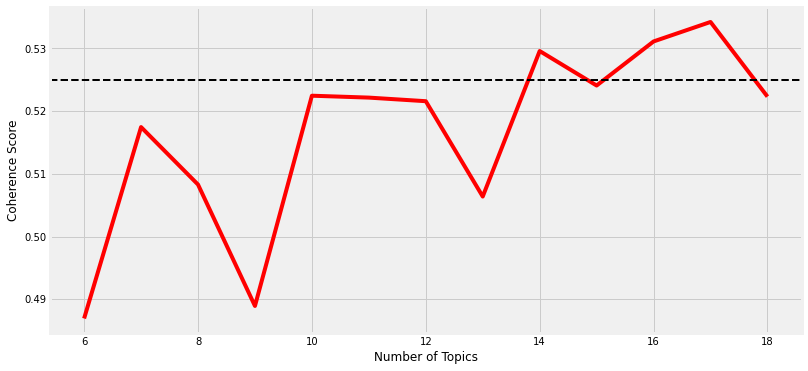

In [ ]:
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(6, 19)                                                                   # Adjust the range based on the number/range of topics you chose
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.525, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
coherence_scores

[0.4869242522980662,
 0.5174551168364557,
 0.5082903708785935,
 0.48892049064452286,
 0.5224630301931937,
 0.5221592880164642,
 0.521586159781423,
 0.5063775210981714,
 0.5295906434429605,
 0.5240856074175767,
 0.5311189209652656,
 0.5342268576971536,
 0.5223166208752573]

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(6, 19),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head()

,Number of Topics,Coherence Score
11,17,0.5342
10,16,0.5311
8,14,0.5296
9,15,0.5241
4,10,0.5225


> #### **C) Determine the Optimal Number of Topics and then rerun model**

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 10].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

10

In [ ]:
topics = [[(term, round(wt, 3))
               for term, wt in best_lda_model.show_topic(n, topn=20)]
                   for n in range(0, best_lda_model.num_topics)]
'''
for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()
'''

"\nfor idx, topic in enumerate(topics):\n    print('Topic #'+str(idx+1)+':')\n    print([term for term, wt in topic])\n    print()\n"

> #### **D) Display as Term-Topic Dataframe**

In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"structure, vector, memory, pattern, representation, rule, node, cluster, code, graph, sequence, bit, level, distance, clustering, capacity, similarity, search, local, feature"
Topic2,"cell, neuron, response, stimulus, activity, pattern, effect, receptive_field, cortical, et_al, layer, unit, synaptic, connection, brain, cortex, firing, neural, mechanism, visual"
Topic3,"neuron, signal, circuit, current, chip, channel, analog, voltage, neural, noise, spike, frequency, delay, threshold, implementation, synapse, computation, gain, source, design"
Topic4,"unit, training, layer, net, hidden_unit, architecture, task, pattern, activation, trained, recurrent, node, rule, back_propagation, generalization, hidden_layer, connectionist, module, prediction, learn"
Topic5,"distribution, estimate, gaussian, variable, probability, prior, sample, mixture, density, prediction, variance, estimation, approximation, bayesian, component, likelihood, noise, regression, log, procedure"
Topic6,"image, object, feature, motion, position, visual, direction, pixel, location, field, view, target, region, representation, filter, local, human, map, subject, surface"
Topic7,"state, control, action, step, task, policy, environment, trajectory, optimal, controller, transition, reinforcement_learning, path, goal, dynamic, robot, current, change, sequence, trial"
Topic8,"class, bound, tree, size, theorem, probability, linear, complexity, threshold, node, theory, machine, loss, approximation, proof, hypothesis, polynomial, defined, distribution, assume"
Topic9,"training, feature, classification, word, recognition, classifier, class, speech, test, experiment, trained, face, character, pattern, table, context, database, vector, training_set, accuracy"
Topic10,"equation, vector, matrix, solution, linear, dynamic, eq, rate, convergence, nonlinear, gradient, noise, optimal, theory, rule, line, find, source, energy, average"


> #### **E) Topic Model Interpretation**

One meaningful way we can interpret our topic models is to see what the most dominant (highest weighted) topics were in specific research papers. Let's create a dataframe containing the document number, its most dominant topic number, the % contribution of that topic, the topic description and an excerpt from the beginning of the paper.

In [ ]:
tm_results = best_lda_model[bow_corpus]                                                           # ~ 21 seconds to run

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                     for topics in tm_results]

corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))                                               # create corpus topic df with specified columns (from instructions)
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([682, 10, 392, 1622, 17,
                        906, 1005, 503, 13, 736])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
10,10,6,36.92,"image, object, feature, motion, position, visual, direction, pixel, location, field, view, target, region, representation, filter, local, human, map, subject, surface","622 \nLEARNING A COLOR ALGORITHM FROM EXAMPLES \nAnya C. Hurlbert and Tomaso A. Poggio \nArtificial Intelligence Laboratory and Department of Brain and Cognitive Sciences, \nMassachusetts Institut..."
13,13,4,40.81,"unit, training, layer, net, hidden_unit, architecture, task, pattern, activation, trained, recurrent, node, rule, back_propagation, generalization, hidden_layer, connectionist, module, prediction,...","442 \nHow Neural Nets Work \nAlan Lapedes \nRobert Father \nTheoretical Division \nLos Alamos National Laboratory \nLos Alamos, NM 87545 \nAbstract: \nThere is presently great interest in the abil..."
17,17,1,42.26,"structure, vector, memory, pattern, representation, rule, node, cluster, code, graph, sequence, bit, level, distance, clustering, capacity, similarity, search, local, feature","174 \nA Neural Network C1A-sifier Based on Coding Theory \nTzi-Dar Chiueh and Rodney Goodman \nCalifornia Institute of Technology, Pasadena, California 91125 \nABSTRACT\nThe new neural network cla..."
392,392,10,24.31,"equation, vector, matrix, solution, linear, dynamic, eq, rate, convergence, nonlinear, gradient, noise, optimal, theory, rule, line, find, source, energy, average",A Framework for the Cooperation \nof Learning Algorithms \nL6on Bottou \nPatrick Gailinari \nLaboratoire de Recherche en Informatique \nUniversit6 de Paris XI \n91405 Orsay Cedex \nFrance \nAbstra...
503,503,5,46.67,"distribution, estimate, gaussian, variable, probability, prior, sample, mixture, density, prediction, variance, estimation, approximation, bayesian, component, likelihood, noise, regression, log, ...","Kernel Regression and \nBackpropagation Training with Noise \nPetri Koistlnen and Lasse HolmstrSm \nRolf Nevanlinna Institute, University of Helsinki \nTeollisuuskatu 23, SF-00510 Helsinki, Finlan..."
682,682,3,38.38,"neuron, signal, circuit, current, chip, channel, analog, voltage, neural, noise, spike, frequency, delay, threshold, implementation, synapse, computation, gain, source, design",Analog VLSI Implementation of \nMulti-dimensional Gradient Descent \nDavid B. Kirk Douglas Kerns Kurt Fleischer Alan H. Barr \nCalifornia Institute of Technology \nBeckman Institute 350-74 \nPa...
736,736,10,41.36,"equation, vector, matrix, solution, linear, dynamic, eq, rate, convergence, nonlinear, gradient, noise, optimal, theory, rule, line, find, source, energy, average","Non-linear Statistical Analysis and \nSelf-Organizing Hebbian Networks \nJonathan L. Shapiro and Adam Priigel-Bennett \nDepartment of Computer Science \nThe University, Manchester \nManchester, UK..."
906,906,4,53.23,"unit, training, layer, net, hidden_unit, architecture, task, pattern, activation, trained, recurrent, node, rule, back_propagation, generalization, hidden_layer, connectionist, module, prediction,...","Learning Many Related Tasks at the \nSame Time With Backpropagation \nRich Caruana \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213 \ncaruana@ cs. cmu .edu \nAbstra..."
1005,1005,8,36.65,"class, bound, tree, size, theorem, probability, linear, complexity, threshold, node, theory, machine, loss, approximation, proof, hypothesis, polynomial, defined, distribution, assume","Using Pairs of Data-Points to Define \nSplits for Decision Trees \nGeoffrey E. Hinton \nDepartment of Computer Science \nUniversity of Toronto \nToronto, Ontario, M5S 1A4, Canada \nhinton@cs.toron..."
1622,1622,3,38.29,"neuron, signal, circuit, current, chip, channel, analog, voltage, neural, noise, spike, frequency, delay, threshold, implementation, synapse, computation, gain, source, design","Information Capacity and Robustness of \nStochastic Neuron Models \nElad Schneidman Idan Segev Naftali Tishby \nInstitute of Computer Science, \

**Examine several of the papers displayed in the dataframe. What characterizes the dominant topics for these papers? Do they reasonably match up with the paper title?**

Most of these papers had to do with Machine Learning, and more specifically, neural networks.

I would say so. If look at the topics description, I actually have a pretty good idea of what the papers are about (in general). I may not get specifics but I do get the gist.

**What is another context, other than trying to briefly summarize the overall themes/topics, where topic modeling could be useful?**

Topic modeling can be useful when analyzing reviews or customer feedback forms. It can also be useful when a company or individual doesn't have time to read through documents or articles. Once a model is trained they provide a template for directly and indirectly reading inputs for further analysis. This significantly reduces the time a person would have to take to read through a match up of documents. Some applications of this include modeling emails, contracts, accounting documents, etc.

One idea I had in regards to applications of topic modeling is to take laws (Since that text data would be easily accessable) for some topic (for example, gun control) across 50 states, and see how similar certain laws on the same topic are written. Then compare that to perhaps crime statistics for that state. Is there any correlation between certain provisions written in our laws and crime/violence?